In [1]:
import obspy
from obspy.signal.cross_correlation import xcorr_pick_correction

In [2]:
# read example data of two small earthquakes
path = "https://examples.obspy.org/BW.UH1..EHZ.D.2010.147.%s.slist.gz"
st1 = obspy.read(path % ("a", ))
st2 = obspy.read(path % ("b", ))

In [3]:
# select the single traces to use in correlation.
# to avoid artifacts from preprocessing there should be some data left and
# right of the short time window actually used in the correlation.
tr1 = st1.select(component="Z")[0]
tr2 = st2.select(component="Z")[0]
# these are the original pick times set during routine analysis
t1 = obspy.UTCDateTime("2010-05-27T16:24:33.315000Z")
t2 = obspy.UTCDateTime("2010-05-27T16:27:30.585000Z")

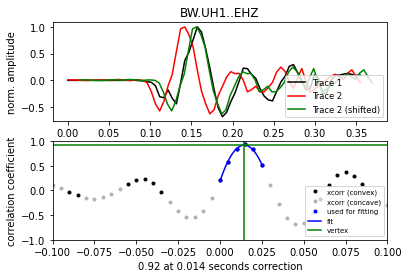

No preprocessing:
  Time correction for pick 2: -0.014459
  Correlation coefficient: 0.92


In [4]:
# estimate the time correction for pick 2 without any preprocessing and open
# a plot window to visually validate the results
dt, coeff = xcorr_pick_correction(t1, tr1, t2, tr2, 0.05, 0.2, 0.1, plot=True)
print("No preprocessing:")
print("  Time correction for pick 2: %.6f" % dt)
print("  Correlation coefficient: %.2f" % coeff)

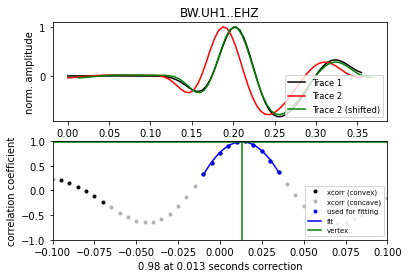

Bandpass prefiltering:
  Time correction for pick 2: -0.013025
  Correlation coefficient: 0.98


In [5]:
# estimate the time correction with bandpass prefiltering
# t_before, t_after, cc_maxlag,
dt, coeff = xcorr_pick_correction(t1, tr1, t2, tr2, t_before=0.05, t_after=0.2, cc_maxlag=0.1, plot=True,
                                  filter="bandpass",
                                  filter_options={'freqmin': 1, 'freqmax': 10})
print("Bandpass prefiltering:")
print("  Time correction for pick 2: %.6f" % dt)
print("  Correlation coefficient: %.2f" % coeff)

https://docs.obspy.org/_modules/obspy/signal/cross_correlation.html#xcorr_pick_correction

In [4]:
# check imported data
print('tr1 ID: {}'.format(tr1.id))
print('tr1 sampling rate: {}'.format(tr1.stats.sampling_rate))
print('tr1 starttime: {}'.format(tr1.stats.starttime))
print('tr1 end time: {}'.format(tr1.stats.endtime))
#print('{}'.format())
print('')
print('tr2 ID: {}'.format(tr2.id))
print('tr2 sampling rate: {}'.format(tr2.stats.sampling_rate))
print('tr2 starttime: {}'.format(tr2.stats.starttime))
print('tr2 end time: {}'.format(tr2.stats.endtime))
#print('{}'.format())

tr1 ID: BW.UH1..EHZ
tr1 sampling rate: 200.0
tr1 starttime: 2010-05-27T16:24:29.315000Z
tr1 end time: 2010-05-27T16:24:39.315000Z

tr2 ID: BW.UH1..EHZ
tr2 sampling rate: 200.0
tr2 starttime: 2010-05-27T16:27:26.585000Z
tr2 end time: 2010-05-27T16:27:36.585000Z


In [5]:
tr1.data

array([269, 266, 238, ..., 373, 208, 129])

In [6]:
# don't modify existing traces with bandpass-filters
tr1 = tr1.copy()
tr2 = tr2.copy()
samp_rate = tr1.stats.sampling_rate

In [7]:
t_before=0.05
t_after=0.2
cc_maxlag=0.1
plot=True
filter="bandpass"
filter_options={'freqmin': 1, 'freqmax': 10}

In [8]:
import numpy as np
from obspy.signal.invsim import cosine_taper
# check data, apply filter and take correct slice of traces
slices = []
for _i, (t, tr) in enumerate(((t1, tr1), (t2, tr2))):
    start = t - t_before - (cc_maxlag / 2.0)
    end = t + t_after + (cc_maxlag / 2.0)
    duration = end - start

    # apply signal processing and take correct slice of data
    if filter:
        tr.data = tr.data.astype(np.float64)
        tr.detrend(type='demean')
        tr.data *= cosine_taper(len(tr), 0.1)
        tr.filter(type=filter, **filter_options)
    slices.append(tr.slice(start, end))

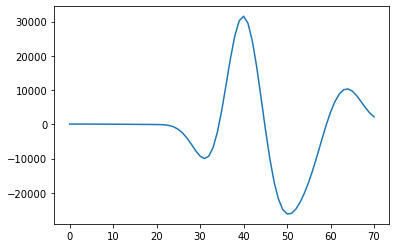

In [9]:
import matplotlib.pyplot as plt
plt.plot(slices[0].data)

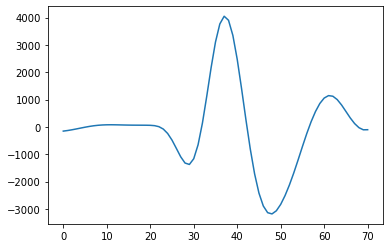

In [10]:
plt.plot(slices[1].data)

In [11]:
len(slices[0])

71

In [24]:
# np.savetxt('tr1.txt', slices[0].data)
# np.savetxt('tr2.txt', slices[1].data)

# a = np.loadtxt('tr1.txt')

In [11]:
from obspy import Trace

In [12]:
def correlate(a, b, shift, demean=True, normalize='naive', method='auto'):
    """
    Cross-correlation of two signals up to a specified maximal shift.

    This function only allows 'naive' normalization with the overall
    standard deviations. This is a reasonable approximation for signals of
    similar length and a relatively small shift parameter
    (e.g. noise cross-correlation).
    If you are interested in the full cross-correlation function better use
    :func:`~obspy.signal.cross_correlation.correlate_template` which also
    provides correct normalization.

    :type a: :class:`~numpy.ndarray`, :class:`~obspy.core.trace.Trace`
    :param a: first signal
    :type b: :class:`~numpy.ndarray`, :class:`~obspy.core.trace.Trace`
    :param b: second signal to correlate with first signal
    :param int shift: Number of samples to shift for cross correlation.
        The cross-correlation will consist of ``2*shift+1`` or
        ``2*shift`` samples. The sample with zero shift will be in the middle.
    :param bool demean: Demean data beforehand.
    :param normalize: Method for normalization of cross-correlation.
        One of ``'naive'`` or ``None``
        (``True`` and ``False`` are supported for backwards compatibility).
        ``'naive'`` normalizes by the overall standard deviation.
        ``None`` does not normalize.
    :param str method: Method to use to calculate the correlation.
         ``'direct'``: The correlation is determined directly from sums,
         the definition of correlation.
         ``'fft'`` The Fast Fourier Transform is used to perform the
         correlation more quickly.
         ``'auto'`` Automatically chooses direct or Fourier method based on an
         estimate of which is faster. (Only availlable for SciPy versions >=
         0.19. For older Scipy version method defaults to ``'fft'``.)

    :return: cross-correlation function.

    To calculate shift and value of the maximum of the returned
    cross-correlation function use
    :func:`~obspy.signal.cross_correlation.xcorr_max`.

    .. note::

        For most input parameters cross-correlation using the FFT is much
        faster.
        Only for small values of ``shift`` (approximately less than 100)
        direct time domain cross-correlation migth save some time.

    .. note::

        If the signals have different length, they will be aligned around
        their middle. The sample with zero shift in the cross-correlation
        function corresponds to this correlation:

        ::

            --aaaa--
            bbbbbbbb

        For odd ``len(a)-len(b)`` the cross-correlation function will
        consist of only ``2*shift`` samples because a shift of 0
        corresponds to the middle between two samples.

    .. rubric:: Example

    >>> from obspy import read
    >>> a = read()[0][450:550]
    >>> b = a[:-2]
    >>> cc = correlate(a, b, 2)
    >>> cc
    array([ 0.62390515,  0.99630851,  0.62187106, -0.05864797, -0.41496995])
    >>> shift, value = xcorr_max(cc)
    >>> shift
    -1
    >>> round(value, 3)
    0.996
    """
    if normalize is False:
        normalize = None
    if normalize is True:
        normalize = 'naive'
    # if we get Trace objects, use their data arrays
    if isinstance(a, Trace):
        a = a.data
    if isinstance(b, Trace):
        b = b.data
    a = np.asarray(a)
    b = np.asarray(b)
    if demean:
        a = a - np.mean(a)
        b = b - np.mean(b)
    # choose the usually faster xcorr function for each method
    _xcorr = _xcorr_padzeros if method == 'direct' else _xcorr_slice
    cc = _xcorr(a, b, shift, method)
    if normalize == 'naive':
        norm = (np.sum(a ** 2) * np.sum(b ** 2)) ** 0.5
        if norm <= np.finfo(float).eps:
            # norm is zero
            # => cross-correlation function will have only zeros
            cc[:] = 0
        elif cc.dtype == float:
            cc /= norm
        else:
            cc = cc / norm
    elif normalize is not None:
        raise ValueError("normalize has to be one of (None, 'naive'))")
    return cc


In [13]:
def _xcorr_padzeros(a, b, shift, method):
    """
    Cross-correlation using SciPy with mode='valid' and precedent zero padding.
    """
    if shift is None:
        shift = (len(a) + len(b) - 1) // 2
    dif = len(a) - len(b) - 2 * shift
    if dif > 0:
        b = _pad_zeros(b, dif // 2)
    else:
        a = _pad_zeros(a, -dif // 2)
    return scipy.signal.correlate(a, b, mode='valid', method=method)


In [14]:
def _pad_zeros(a, num, num2=None):
    """Pad num zeros at both sides of array a"""
    if num2 is None:
        num2 = num
    hstack = [np.zeros(num, dtype=a.dtype), a, np.zeros(num2, dtype=a.dtype)]
    return np.hstack(hstack)

In [15]:
import scipy
# cross correlate
shift_len = int(cc_maxlag * samp_rate)
cc = correlate(slices[0].data, slices[1].data, shift_len, method='direct')
# _cc_shift, cc_max = xcorr_max(cc)
cc_curvature = np.concatenate((np.zeros(1), np.diff(cc, 2), np.zeros(1)))
# cc_convex = np.ma.masked_where(np.sign(cc_curvature) >= 0, cc)
# cc_concave = np.ma.masked_where(np.sign(cc_curvature) < 0, cc)

In [16]:
# make array with time shifts in seconds corresponding to cc function
cc_t = np.linspace(-cc_maxlag, cc_maxlag, shift_len * 2 + 1)

In [17]:
# take the subportion of the cross correlation around the maximum that is
# convex and fit a parabola.
# use vertex as subsample resolution best cc fit.
peak_index = cc.argmax()
first_sample = peak_index
# XXX this could be improved..
while first_sample > 0 and cc_curvature[first_sample - 1] <= 0:
    first_sample -= 1
last_sample = peak_index
while last_sample < len(cc) - 1 and cc_curvature[last_sample + 1] <= 0:
    last_sample += 1

# work on subarrays
num_samples = last_sample - first_sample + 1

In [18]:
# quadratic fit for small subwindow
coeffs, residual = np.polyfit(
    cc_t[first_sample:last_sample + 1],
    cc[first_sample:last_sample + 1], deg=2, full=True)[:2]

In [19]:
# X coordinate of vertex of parabola gives time shift to correct
# differential pick time. Y coordinate gives maximum correlation
# coefficient.
dt = -coeffs[1] / 2.0 / coeffs[0]
coeff = (4 * coeffs[0] * coeffs[2] - coeffs[1] ** 2) / (4 * coeffs[0])
# this is the shift to apply on the time axis of `trace2` to align the
# traces. Actually we do not want to shift the trace to align it but we
# want to correct the time of `pick2` so that the traces align without
# shifting. This is the negative of the cross correlation shift.
dt = -dt
pick2_corr = dt

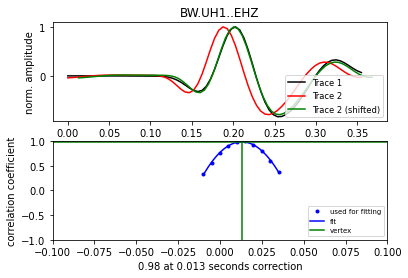

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
tmp_t = np.linspace(0, len(slices[0]) / samp_rate, len(slices[0]))
ax1.plot(tmp_t, slices[0].data / float(slices[0].data.max()), "k",
         label="Trace 1")
ax1.plot(tmp_t, slices[1].data / float(slices[1].data.max()), "r",
         label="Trace 2")
ax1.plot(tmp_t - dt, slices[1].data / float(slices[1].data.max()),
         "g", label="Trace 2 (shifted)")
ax1.legend(loc="lower right", prop={'size': "small"})
ax1.set_title("%s" % slices[0].id)
ax1.set_xlabel("time [s]")
ax1.set_ylabel("norm. amplitude")
ax2 = fig.add_subplot(212)
# ax2.plot(cc_t, cc_convex, ls="", marker=".", color="k",
#          label="xcorr (convex)")
# ax2.plot(cc_t, cc_concave, ls="", marker=".", color="0.7",
#          label="xcorr (concave)")
ax2.plot(cc_t[first_sample:last_sample + 1],
         cc[first_sample:last_sample + 1], "b.",
         label="used for fitting")
tmp_t = np.linspace(cc_t[first_sample], cc_t[last_sample],
                    num_samples * 10)
ax2.plot(tmp_t, np.polyval(coeffs, tmp_t), "b", label="fit")
ax2.axvline(-dt, color="g", label="vertex")
ax2.axhline(coeff, color="g")
ax2.set_xlabel("%.2f at %.3f seconds correction" % (coeff, -dt))
ax2.set_ylabel("correlation coefficient")
ax2.set_ylim(-1, 1)
ax2.set_xlim(cc_t[0], cc_t[-1])
ax2.legend(loc="lower right", prop={'size': "x-small"})
